In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras import Sequential
from sklearn.model_selection import train_test_split
import pickle
from cmath import sqrt
import math


In [2]:
#Operating Conditions
Temperature = 24.93 + 273 # (°C)
Irradiance = 760.78 # (W/m^2)
Wind_speed = 4 # (m/s)

# 31.42, 664.71
Rload = 10

In [3]:
# Physical constants
k = 1.38065e-23  # Boltzmann constant (J/K)
q = 1.602e-19  # Electron charge (C)

In [4]:
#PV System Parameters
Rs = 0.221  # Series resistance (Ω)
Rp = 415.405  # Shunt resistance (Ω)
Kv = -0.123  # Temperature voltage constant (V/°C)
Ki = 0.0032  # Temperature current constant (A/°C)
Iscn = 8.21  # Nominal short-circuit current (A)
Vocn = 32.9  # Nominal open-circuit voltage (V)
Ns = 54  # Number of series-connected cells
a = 1.3  # Diode ideality factor
Eg = 1.12  # Band gap of silicon at 25°C (eV)

T = Temperature
G = Irradiance
Tn = 25 + 273  # Nominal temperature (K)
Gn = 1000  # Nominal irradiance (W/m^2)

V = np.arange(32.9, 0, -0.001)  # Voltage sweep (V)
I = np.zeros_like(V)  # Output current (A)
P = np.zeros_like(V)  # Output power (W)


In [5]:
#Wind System Parameters
R = 2
Beta = 0
rho = 1.22
A = 3.14*(R^2)

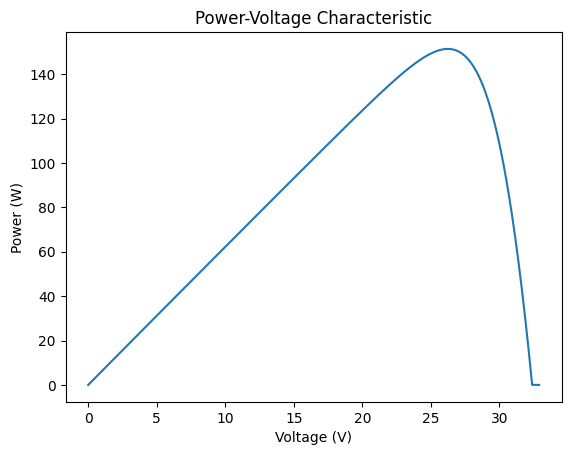

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


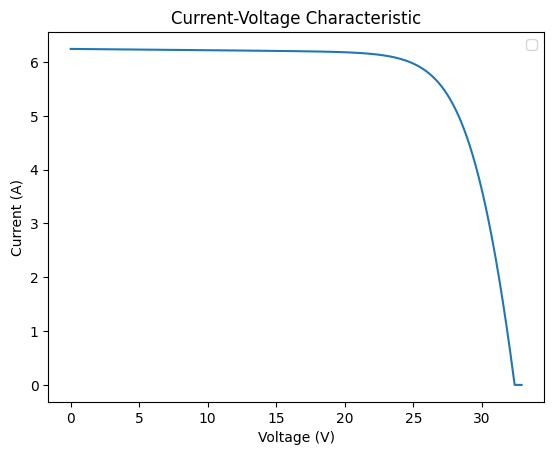

Voltage at which MPP occurs: 26.24000000001552
Max Power: 151.34154422485219


In [6]:
#PV System
Vtn = Ns * (k * Tn / q)

Ion = Iscn / ((np.exp(Vocn / (a * Vtn)) - 1))
Io = Ion * ((T / Tn)**3) * np.exp((q * Eg / (a * k)) * ((1 / Tn) - (1 / T)))

Ipvn = Iscn
Ipv = (Ipvn + Ki * (T - Tn)) * (G / Gn)

Vt = Ns * (k * T / q)

for i in range(len(V)):
    I_part = Io * (np.exp((V[i] + (I[i - 1] * Rs)) / (Vt * a)) - 1) + ((V[i] + (Rs * I[i - 1])) / Rp)
    I[i] = Ipv - I_part
    P[i] = V[i] * I[i]


# Clip power values to zero if they are less than or equal to zero
P = np.clip(P, 0, None)
I = np.clip(I, 0, None)

# Plot the power versus voltage
plt.plot(V, P)
plt.xlabel('Voltage (V)')
plt.ylabel('Power (W)')
plt.title('Power-Voltage Characteristic')
#plt.grid(True)
plt.show()

# Plot the current versus voltage
plt.plot(V, I)
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')
plt.title('Current-Voltage Characteristic')
plt.legend()
#plt.grid(True)
plt.show()

# Find MPP and maximum power
print("Voltage at which MPP occurs:", V[np.argmax(P)])
print("Max Power:", P[np.argmax(P)])

C:\Users\amans\AppData\Local\Temp\ipykernel_37976\1263557100.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  return (1 / (lambda_val + 0.08 * beta)) - (0.035 / (beta**3 + 1))
C:\Users\amans\AppData\Local\Temp\ipykernel_37976\1263557100.py:8: RuntimeWarning: invalid value encountered in scalar multiply
  term1 = (116 * inverse_lambda_i - 0.4 * beta - 5) * math.exp(-21 * inverse_lambda_i)


<Figure size 1000x600 with 0 Axes>

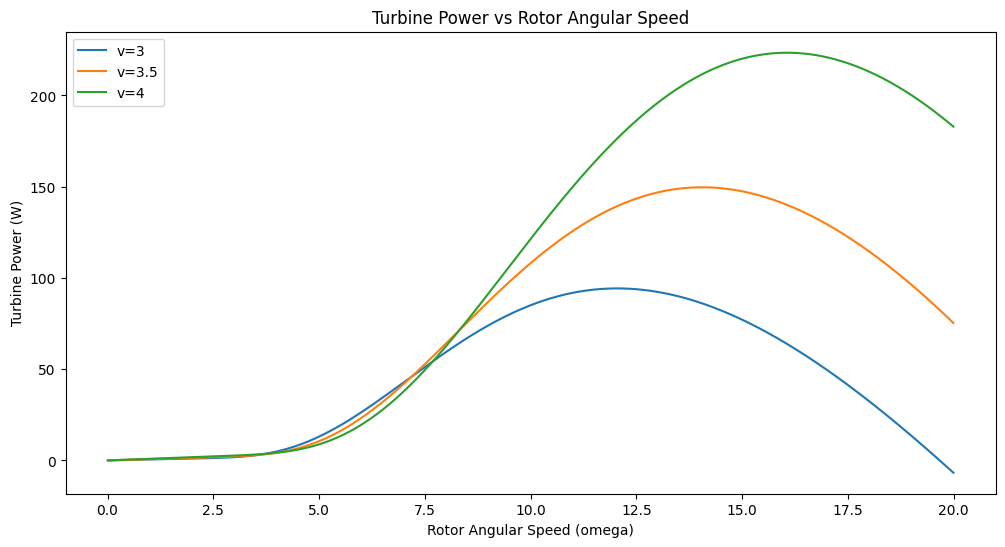

In [7]:
def calculate_lambda(omega, R, v):
    return omega * R / v

def inverse_lambda_i(beta, lambda_val):
    return (1 / (lambda_val + 0.08 * beta)) - (0.035 / (beta**3 + 1))

def Cp(inverse_lambda_i, lambda_val, beta):
    term1 = (116 * inverse_lambda_i - 0.4 * beta - 5) * math.exp(-21 * inverse_lambda_i)
    term2 = 0.0068 * lambda_val
    return 0.5176 * (term1 + term2)

def calculate_actual_power(v, A, rho, Cp, beta):
    P = 0.5 * rho * A * v**3 * Cp
    return P

beta = 0
R = 2
v = Wind_speed

omega_vals = np.arange(0, 25, 0.01)
lambda_vals = [calculate_lambda(omega, R, v) for omega in omega_vals]

beta_values = np.arange(0, 15, 2)  # Define a range of beta values

plt.figure(figsize=(10, 6))

# Parameters for power calculation
A = math.pi * R**2  # rotor area
rho = 1.225  # air density (kg/m^3)

v_values = [3,3.5,4]

omega_vals1 = np.arange(0, 20, 0.01)

plt.figure(figsize=(12, 6))

for v in v_values:
    inverse_lambda_vals = [inverse_lambda_i(beta, calculate_lambda(omega, R, v)) for omega in omega_vals1]
    Cp_vals = [Cp(inv_lambda, calculate_lambda(omega, R, v), beta) for inv_lambda, omega in zip(inverse_lambda_vals, omega_vals1)]
    actual_power_vals = [calculate_actual_power(v, A, rho, Cp_val, beta) for Cp_val in Cp_vals]
    plt.plot(omega_vals1, actual_power_vals, label=f'v={v}')


plt.xlabel("Rotor Angular Speed (omega)")
plt.ylabel("Turbine Power (W)")
plt.legend()
plt.title("Turbine Power vs Rotor Angular Speed")
#plt.grid(True)
plt.show()

Text(0, 0.5, 'Power(W)')

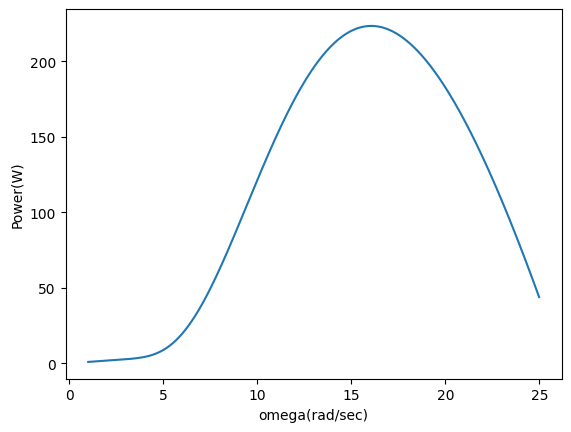

In [8]:
Pmax = []
omega_for_Pmax = []
v = Wind_speed

if not np.isnan(v) and np.isfinite(v):  # Check if v is not NaN or infinite
    omega_vals = np.arange(1, 25, 0.01)
    inverse_lambda_vals = [inverse_lambda_i(beta, calculate_lambda(omega, R, v)) for omega in omega_vals]
    Cp_vals = [Cp(inv_lambda, calculate_lambda(omega, R, v), beta) for inv_lambda, omega in zip(inverse_lambda_vals, omega_vals)]
    actual_power_vals = [calculate_actual_power(v, A, rho, Cp_val, beta) for Cp_val in Cp_vals]
    if actual_power_vals:  # Check if the list is not empty
        max_power_index = np.argmax(actual_power_vals)
        Pmax.append(actual_power_vals[max_power_index])
        omega_for_Pmax.append(omega_vals[max_power_index])
    else:
        Pmax.append(0)  # Default value if actual_power_vals is empty
        omega_for_Pmax.append(0)  # Default value if actual_power_vals is empty
else:
    Pmax.append(0)  # Default value if v is NaN or infinite
    omega_for_Pmax.append(0)   # Default value if v is NaN or infinite

plt.plot(omega_vals, actual_power_vals)
plt.xlabel('omega(rad/sec)')
plt.ylabel('Power(W)')

In [9]:
# Creating a dictionary with the input values
data = {'Irradiance': [G], 'Temperature': [T - 273]}

# Converting the dictionary into a pandas DataFrame
X = pd.DataFrame(data)
print(X)

data1 = {'windspeed': [Wind_speed]}

Y = pd.DataFrame(data1)
print(Y)

   Irradiance  Temperature
0      760.78        24.93
   windspeed
0          4


In [10]:
Pkl_Filename = "saved_model.pkl"  


# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    ann_pv = pickle.load(file)

ann_pv

In [11]:
Pkl_Filename = "saved_wind_model.pkl"  


# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    wind_model = pickle.load(file)

wind_model

In [12]:
PVMPP = ann_pv.predict(X)
print(PVMPP)

1/1 [==============================] - 0s 211ms/step
[[ 26.707132 150.83826 ]]


In [13]:
WindMPP = wind_model.predict(Y)
print(WindMPP)

1/1 [==============================] - 0s 64ms/step
[[223.13853   15.524913]]


In [14]:
V_pv = PVMPP[0][0]
P_pv = PVMPP[0][1]

d1 = 1 - (V_pv / sqrt(P_pv*Rload))
d1 = d1.real

print(d1)

0.3123435735336222


In [15]:
wm = WindMPP[0][1]
Va = 162.33*0.01*wm
Pwind = WindMPP[0][0]

d2 = 1 - (Va / sqrt(Pwind*Rload))
d2 = d2.real

print(d2)

0.46649232582811684


In [16]:
dpv = np.zeros(len(I))

for i in range(len(I)):
    if I[i]>0:
        dpv[i] = 1 - ((V[i]/(I[i]*Rload))**0.5)
        if dpv[i] < 0:
            dpv[i] = 0
    else:
        dpv[i] = 1


In [17]:
Vterminal = 162.33*0.01*omega_vals
dwind = np.zeros(len(Vterminal))
actual_power_vals = np.clip(actual_power_vals, 0, None)
Iterminal = actual_power_vals/Vterminal

for i in range(len(Iterminal)):
    if Iterminal[i]>0:
        dwind[i] = 1 - ((Vterminal[i]/(Iterminal[i]*Rload))**0.5)
        if dwind[i] < 0:
            dwind[i] = 0
    else:
        dwind[i] = 1

print(dwind)

[0.44866669 0.44591688 0.44318065 ... 0.         0.         0.        ]


In [18]:
iter_max_pv = 2000
iter_max_wind = 200

In [19]:
def PandOpv(dprev, iter_max):

    iter = iter_max
    deld = 0.0001

    ind = np.argmin(abs(dpv - dprev))

    Pprev = V[ind] * I[ind]
    Vprev = V[ind]

    d = dprev + 0.001

    Parray = np.zeros(iter)
    countarray = np.zeros(iter)
    count = 0

    for i in range(iter):
        count+=1

        index = np.argmin(abs(dpv - d))

        Pnew = V[index] * I[index]
        Vnew = V[index]

        delP = Pnew - Pprev
        delV = Vnew - Vprev

        if delP != 0:
            if delP > 0:
                if delV > 0:
                    d = d -deld
                else: 
                    d+=deld
            else:
                if delV > 0:
                    d+=deld
                else:
                    d-=deld
        else:
            d = dprev

        dprev = d
        Pprev = Pnew
        Vprev = Vnew

        Parray[i] = Pnew
        countarray[i] = count
    return Parray, countarray, d

In [20]:
def PandOwind(wprev, iter_max):

    iter = iter_max
    delw = 0.1

    ind = np.argmin(abs(omega_vals-wprev))

    Pprev = actual_power_vals[ind]
    Omegaprev = omega_vals[ind]

    w = wprev + 0.3

    Parray = np.zeros(iter)
    countarray = np.zeros(iter)
    count = 0

    for i in range(iter):
        count+=1

        index = np.argmin(abs(omega_vals - w))

        Pnew = actual_power_vals[index]
        omeganew = omega_vals[index]

        delP = Pnew - Pprev
        delomega = omeganew - Omegaprev

        if delP != 0:
            if delP > 0:
                if delomega > 0:
                    w = w + delw
                else: 
                    w-=delw
            else:
                if delomega > 0:
                    w-=delw
                else:
                    w+=delw
        else:
            w = Omegaprev

        Pprev = Pnew
        Omegaprev = omeganew

        Parray[i] = Pnew
        countarray[i] = count
    
    return Parray, countarray, w

In [21]:
d_previous = 0.3015
Parrpv, countarrpv, d_actual = PandOpv(d_previous,iter_max_pv)

In [22]:
Parrayann, countarrayann, d_actual1 = PandOpv(d1,iter_max_pv)

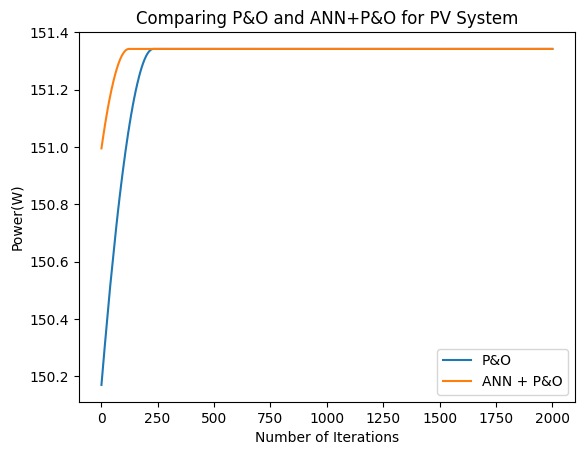

In [23]:
plt.plot(countarrpv, Parrpv, label = 'P&O')
plt.plot(countarrayann, Parrayann, label = 'ANN + P&O')
plt.legend()
plt.xlabel('Number of Iterations')
plt.ylabel('Power(W)')
plt.title('Comparing P&O and ANN+P&O for PV System')
plt.show()

Text(0.5, 1.0, 'Zoomed in Graph of P&O Reaching MPP After Duty Ratio Input from ANN')

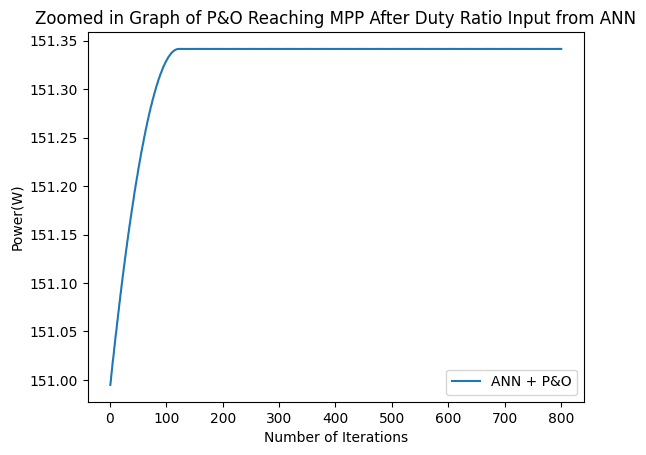

In [24]:
rangex = np.arange(1, 801)
plt.plot(rangex, Parrayann[0:800], label = 'ANN + P&O')
plt.legend()
plt.xlabel('Number of Iterations')
plt.ylabel('Power(W)')
plt.title('Zoomed in Graph of P&O Reaching MPP After Duty Ratio Input from ANN')

Text(0.5, 1.0, 'Comparing P&O and ANN+P&O for WECS')

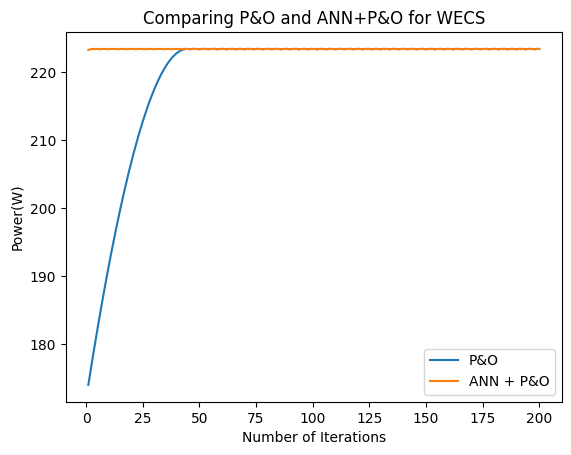

In [25]:
#Omegaprev = 12.02
dprev = 0.5053
Pprev = 436.37
Omegaprev = ((1-dprev)*((Pprev*Rload)**0.5))/(162.33*0.01)

Parraywind, countarraywind, omega_actual = PandOwind(Omegaprev, iter_max_wind)

Parraywindann, countarraywindann, omega_actualann = PandOwind(wm, iter_max_wind)

plt.plot(countarraywind, Parraywind, label = 'P&O')
plt.plot(countarraywind, Parraywindann, label = 'ANN + P&O')
plt.legend()
plt.xlabel('Number of Iterations')
plt.ylabel('Power(W)')
plt.title('Comparing P&O and ANN+P&O for WECS')

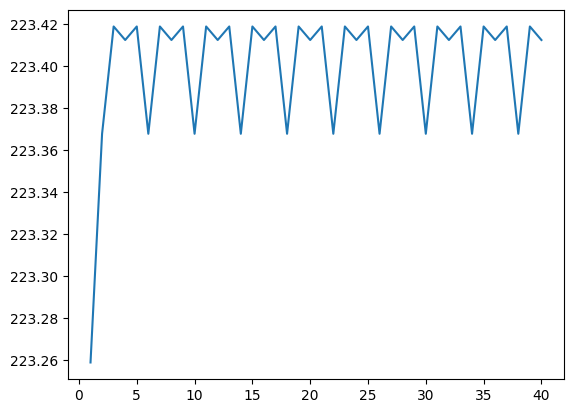

In [26]:
rangexw = np.arange(1, 41)
plt.plot(rangexw, Parraywindann[0:40], label = 'ANN + P&O')

In [27]:
Vterminal = 162.33*0.01*omega_actualann
d20 = 1 - (Vterminal / sqrt(max(Parraywindann)*Rload))
d20 = d20.real

print(d20)

0.44965540152540917


In [28]:
print(d2)

0.46649232582811684


In [29]:
print(d_actual1)

0.32534357353362087


In [30]:
print(d1)

0.3123435735336222


In [31]:
print(wm)

15.524913


In [32]:
print(omega_actualann)

16.02491283416748


In [33]:
print(omega_actual)

16.031241765893977


In [34]:
print(max(actual_power_vals))

223.42299971500793


In [163]:
datapv = pd.read_csv('data_with_mpp.csv')
datapv = datapv.drop('YEAR', axis = 1)
datapv = datapv.drop('MO', axis = 1)
datapv = datapv.drop('DY', axis = 1)
datapv = datapv.drop('HR', axis = 1)
datapv = datapv.drop('TIMESTAMP', axis = 1)
datapv = datapv.sample(n=25)
Ypv = datapv[["MPP_Voltage", "MPP_Power"]]
Xpv = datapv[["G", "T"]]

1/1 [==============================] - 0s 103ms/step


Text(0.5, 1.0, 'Comparing Predicted Values with Actual Values for PVS')

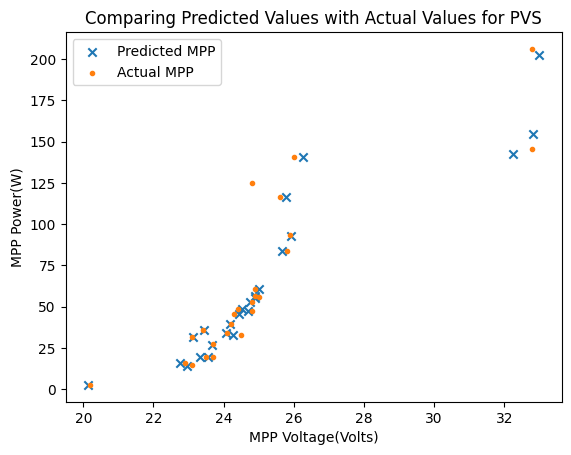

In [183]:
predYpv = ann_pv.predict(Xpv)

Vpvpred = np.zeros(len(predYpv))
Ppvpred = np.zeros(len(predYpv))

for i in range(len(predYpv)):
    Vpvpred[i] = predYpv[i][0]
    Ppvpred[i] = predYpv[i][1]


plt.scatter(Vpvpred, Ppvpred, marker="x", label = 'Predicted MPP')
plt.scatter(Ypv["MPP_Voltage"], Ypv["MPP_Power"], marker=".", label = 'Actual MPP')
plt.legend()
plt.xlabel("MPP Voltage(Volts)")
plt.ylabel("MPP Power(W)")
plt.title("Comparing Predicted Values with Actual Values for PVS")

In [198]:
datawind = pd.read_csv('windData_with_Pmax.csv')
datawind = datawind.drop('YEAR', axis = 1)
datawind = datawind.drop('MO', axis = 1)
datawind = datawind.drop('DY', axis = 1)
datawind = datawind.drop('HR', axis = 1)
datawind = datawind.sample(n=25)
Ywind = datawind[['Pmax', 'omega_for_Pmax']]
Xwind = datawind[['WS10M']]

1/1 [==============================] - 0s 31ms/step


Text(0.5, 1.0, 'Comparing Predicted Values with Actual Values for WECS')

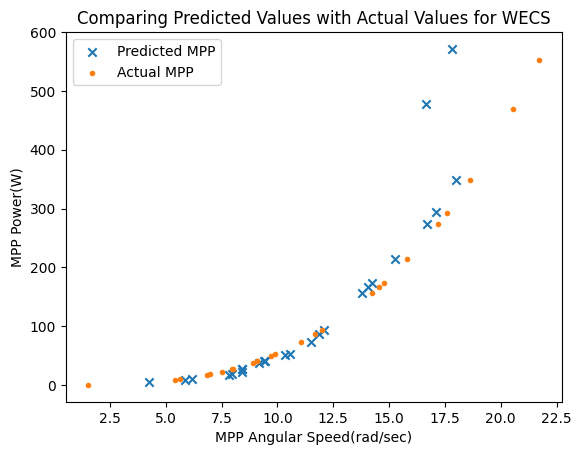

In [199]:
predYwind = wind_model.predict(Xwind)

Wwindpred = np.zeros(len(predYwind))
Pwindpred = np.zeros(len(predYwind))

for i in range(len(predYpv)):
    Wwindpred[i] = predYwind[i][1]
    Pwindpred[i] = predYwind[i][0]


plt.scatter(Wwindpred, Pwindpred, marker="x", label = 'Predicted MPP')
plt.scatter(Ywind["omega_for_Pmax"], Ywind["Pmax"], marker=".", label = 'Actual MPP')
plt.legend()
plt.xlabel("MPP Angular Speed(rad/sec)")
plt.ylabel("MPP Power(W)")
plt.title("Comparing Predicted Values with Actual Values for WECS")